In [1]:
# Import internal libraries
import glob

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Analyze reliability, bandwidth, energy
data = []
datadir = "data"
for bpc in range(1, 3):
    for alias in ["slow", "ispp"]:
        for att in range(16, 256, 32):
            # Real max attempts
            att = (att & 31) << (att >> 5)

            # Load and compute data
            try:
                diag = open(f"{datadir}/diag_{bpc}bpc_{alias}_{att}.json")
                postread = np.loadtxt(f"{datadir}/postread_{bpc}bpc_{alias}_{att}.csv", delimiter=',', dtype=np.int8)
                dt = np.loadtxt(f"{datadir}/dt_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                ivdd_and_dac = np.loadtxt(f"{datadir}/vdd_and_dac_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                ivsa = np.loadtxt(f"{datadir}/vsa_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                ivddio = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                ivddio_dac = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
            except OSError:
                continue
            power_tot = ivdd_and_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
            energy_tot = power_tot * dt
            bw = 2**16 * 48 * bpc / dt # bits per second
            energy_per_bit = energy_tot / 2**16 / 48 / bpc
            edp = energy_per_bit / bw

            # Load data into confmat
            confmat = np.zeros(shape=(2**bpc, 2**bpc))
            for i in range(65536):
                for j in range(48):
                    if j in [19,24,29,38,43]:
                        continue
                    confmat[j % (2**bpc)][postread[i][j]] += 1
            confmat = confmat.astype(int)
            print(confmat)

            # Symbol error magnitudes
            mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
            rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

            # Function to get Gray code string
            getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

            # Function to get Gray code error rate for each possible symbol confusion
            grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

            # BER and CER
            ber = (grayerr * confmat).sum() / confmat.sum()
            cer = 1 - confmat.trace() / confmat.sum()
            
            # Compose dataframe
            data.append({"att": att, "bpc": bpc, "dt": dt, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse})
data = pd.DataFrame(data)
data

[[1308687  133105]
 [ 373611 1002645]]
[[1364275   77517]
 [ 192554 1183702]]
[[1387167   54625]
 [  20850 1355406]]
[[1421412   20380]
 [   4836 1371420]]
[[1433495    8297]
 [    778 1375478]]
[[1439469    2323]
 [    126 1376130]]
[[1441325     467]
 [     22 1376234]]
[[1441693      99]
 [     23 1376233]]


,att,bpc,dt,power_tot,energy_per_bit,edp,bw,cer,ber,mae,rmse
0,16,1,0.3143916130065918,0.006434,6.429870e-10,6.426167e-17,1.000576e+07,0.179811,0.179811,0.179811,0.424041
1,32,1,0.5184271335601807,0.006906,1.138065e-09,1.875571e-16,6.067831e+06,0.095836,0.095836,0.095836,0.309574
2,64,1,0.9345607757568359,0.007105,2.110752e-09,6.270809e-16,3.365996e+06,0.026783,0.026783,0.026783,0.163654
3,128,1,1.651125431060791,0.006919,3.631554e-09,1.906125e-15,1.905202e+06,0.008948,0.008948,0.008948,0.094594
4,256,1,2.730008363723755,0.006596,5.723901e-09,4.967466e-15,1.152278e+06,0.003220,0.003220,0.003220,0.056748
5,512,1,4.408488035202026,0.006486,9.089932e-09,1.273882e-14,7.135617e+05,0.000869,0.000869,0.000869,0.029480
6,1024,1,6.834438323974609,0.006158,1.337987e-08,2.906922e-14,4.602760e+05,0.000174,0.000174,0.000174,0.013173
7,2048,1,9.958831310272217,0.006035,1.910629e-08,6.048722e-14,3.158732e+05,0.000043,0.000043,0.000043,0.006580


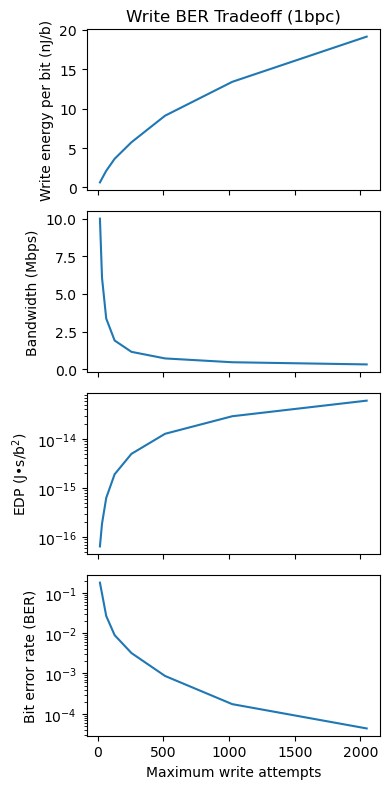

In [5]:
# Plot write BER tradeoff vs. attempts
for bpc, d in data.groupby("bpc"):
    fig, axs = plt.subplots(4, 1, figsize=(4,8), sharex=True)
    plt.xlabel("Maximum write attempts")
    axs[0].set_title(f"Write BER Tradeoff ({bpc}bpc)")
    axs[0].plot(d["att"], d["energy_per_bit"]*1e9)
    # axs[0].set_yscale("log")
    axs[0].set_ylabel("Write energy per bit (nJ/b)")
    axs[1].plot(d["att"], d["bw"]/1e6)
    # axs[1].set_yscale("log")
    axs[1].set_ylabel("Bandwidth (Mbps)")
    axs[2].plot(d["att"], d["edp"])
    axs[2].set_yscale("log")
    axs[2].set_ylabel("EDP (J•s/b$^2$)")
    axs[3].plot(d["att"], d["ber"])
    axs[3].set_yscale("log")
    axs[3].set_ylabel("Bit error rate (BER)")
    plt.tight_layout()
    plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
    plt.show()